In [1]:
%load_ext autoreload 
%autoreload 2

import os
import random
import numpy as np
import scipy.linalg as sl
from PIL import Image
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, CenterCrop, RandomHorizontalFlip, RandomVerticalFlip, ToTensor, Normalize
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
# torch.set_default_device("cuda")
torch.set_default_dtype(torch.float32)
plt.style.use('seaborn-v0_8')

/env_dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [2]:
DATASET_PATH = "/mnt/dl/datasets/Oxford102FlowersSplits/"
os.environ["KERAS_BACKEND"] = "tensorflow"
LABELS = {i: k.strip() for i, k in enumerate(open(os.path.join(DATASET_PATH, "names.txt")))}
img_size = 64
batch_size = 32
num_classes = len(LABELS)
patch_size = 16
num_patches = img_size ** 2 / patch_size **2

In [3]:
class FlowerDataset(Dataset):
    def __init__(self, path, split, cache=True, transforms=None):
        super().__init__()
        self.load_data(path, split)
        self.samples = dict()
        self.transforms = transforms
        
    def load_data(self, path, split):
        path = os.path.join(path, split, )
        img_files = os.listdir(os.path.join(path, "jpeg"))
        img_files = sorted(img_files, key=lambda x: int(x.replace(".jpeg", "")))
        img_files = list(img_files)
        
        labels = list(open(os.path.join(path, "label", "label.txt"),))
        self.labels = [int(l.strip()) for l in labels]
        
        self.img_files = [os.path.join(path, "jpeg", name) for name in img_files]
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, index):
        if index not in self.samples:
            self.load_sample(index)
        sample = self.samples[index]
        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample
        
    def load_sample(self, idx):
        img = Image.open(self.img_files[idx])
        img = np.array(img).astype(np.float32)
        self.samples[idx] = img
        return True


In [4]:
train_ds = FlowerDataset(DATASET_PATH, "train", transforms=Compose([
    ToTensor(),
    Resize((img_size, img_size)),
    RandomHorizontalFlip(0.1),
    RandomVerticalFlip(0.),
    # Normalize(0., 255.),
]))
val_ds = FlowerDataset(DATASET_PATH, "validation", transforms=Compose([
    ToTensor(),
    Resize((img_size, img_size)),
    # Normalize(0., 255.),
]))

test_ds = FlowerDataset(DATASET_PATH, "test", transforms=Compose([
    ToTensor(),
    Resize((img_size, img_size)),
    # Normalize(0., 255.),
]))

In [5]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)

In [6]:
img = train_ds[0].view((1, 3, img_size, img_size))

/env_dl/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Glow

In [7]:
def gaussian_logp(x, mean, log_std):
    return -0.5 * np.log(2 * np.pi) - log_std - 0.5 * (x - mean).square() / (2*log_std).exp()

def gaussian_sample(mean, log_std, eps=None):
    if eps is None:
        eps = torch.randn(log_std.size()).to(mean.device)
    return mean + log_std.exp() * eps

In [8]:
class ActNorm(nn.Module):
    
    def __init__(self, in_channel):
        super().__init__()
        self.scale = nn.Parameter(torch.ones((1, in_channel, 1, 1)))
        self.bias =  nn.Parameter(torch.zeros((1, in_channel, 1, 1)))   
    
    def forward(self, x):
        z = self.scale * x + self.bias
        h, w = x.shape[-2:]
        log_det = h * w * self.scale.abs().log().sum() 
        return z, log_det

    def reverse(self, z):
        x = z - self.bias
        x = x / self.scale
        return x


In [9]:
class InvConvLU(nn.Module):
    
    def __init__(self, in_channel):
        super().__init__()
        self.build_weights(in_channel)
    
    def build_weights(self, in_channel):
        weights = np.random.normal(size=(in_channel, in_channel)).astype(np.float32)
        q, *_ = sl.qr(weights)
        P, L, U = sl.lu(q)
        l_mask = torch.tril(torch.ones((in_channel, in_channel)), -1)

        self.register_buffer("P", torch.tensor(P, dtype=torch.float32))
        self.register_buffer("l_mask", l_mask)
        self.register_buffer("u_mask", l_mask.transpose(0, 1))
        self.register_buffer("diag_mask", torch.eye(in_channel))

        self.diag = nn.Parameter(torch.tensor(np.diag(U), dtype=torch.float32))
        self.L = nn.Parameter(torch.tensor(L, dtype=torch.float32))
        self.U = nn.Parameter(torch.tensor(U, dtype=torch.float32))
    
    def get_weights(self):
        return self.P @ (self.L * self.l_mask + self.diag_mask) @ (torch.diag(self.diag) + self.U * self.u_mask)
        
    def forward(self, x):
        h, w = x.shape[-2:]
        W = self.get_weights()
        # det = torch.linalg.det(W)
        # c =  W.size(0)
        # W = W.view((c, c, 1, 1))
        # z = F.conv2d(x, W, padding=0)
        # # TODO use torch.slogdet
        # log_det = h * w * det.abs().log() 
        
        # New z = W x
        z = torch.einsum("bchw, dc -> bdhw", x, W)
        log_det = h * w * self.diag.abs().log().sum()
        # new_x = self.reverse(z)
        
        return z, log_det
        
    def reverse(self, z):
        W = self.get_weights()
        # c =  W.size(0)
        W_inv = torch.linalg.inv(W)
        x = torch.einsum("bdhw, dc -> bchw", z, W)
        # W = W.view((c, c, 1, 1))
        # x =  F.conv2d(z, W, )
        return x
# torch.manual_seed(0)
# np.random.seed(0)
# InvConvLU(3)(torch.randn((2, 3, 4, 4)))

In [10]:
class AffineCouplingLayer(nn.Module):
    
    def __init__(self, in_channel, filters):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Conv2d(in_channel // 2, filters, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(filters, filters, 1),
            nn.ReLU(),
            nn.Conv2d(filters, in_channel, 3, padding=1),
        )
        with torch.no_grad():
            for i, layer in enumerate(self.modules()):
                if isinstance(layer, nn.Conv2d):
                    layer.weight.data.copy_(torch.normal(-0.005, 0.005, layer.weight.size()))
                    layer.bias.data.copy_(torch.zeros_like(layer.bias))
                
    
    def forward(self, x):
        xa, xb = x.chunk(2, 1)
        flow_param = self.nn(xb)
        log_s, t = flow_param.chunk(2, 1)
        s = log_s.exp()
        za = xa * s + t
        zb = xb
        z = torch.cat([za, zb], 1)
        assert z.size() == x.size() 
        log_det = s.abs().log().reshape((x.size(0), -1)).sum(-1)
        return z, log_det
        
    def reverse(self, z):
        za, zb = z.chunk(2, 1)
        flow_param = self.nn(zb)
        log_s, t = flow_param.chunk(2, 1)
        s = log_s.exp()
        xa = (za - t) / s
        xb = zb
        x = torch.concatenate([xa, xb], dim=1)
        return x
    
# AffineCouplingLayer(3, 512)(img)

In [11]:
class Squeeze(nn.Module):
    
    def forward(self, x):
        bz, c, h, w = x.size()
        x = x.permute((0, 2, 3, 1))
        sqz_x = x.view((bz, h//2, 2, w//2, 2, c)).contiguous()
        sqz_x = sqz_x.permute((0, 1, 3, 2, 4, 5))
        sqz_x = sqz_x.reshape( sqz_x.shape[:-3] + (4*c,) )
        sqz_x = sqz_x.permute((0, 3, 1, 2))
        return sqz_x

    def reverse(self, x):
        x = x.permute((0, 2, 3, 1))
        bz, h, w, c = x.size()
        unsqz_x = x.view((bz, h, w, 2, 2, c // 4))
        unsqz_x = unsqz_x.permute((0, 1, 3, 2, 4, 5))
        unsqz_x = unsqz_x.reshape((bz, 2*h, 2*w, unsqz_x.shape[-1]))
        unsqz_x = unsqz_x.permute((0, 3, 1, 2))
        return unsqz_x  

In [12]:
class FlowModule(nn.Module):
    def __init__(self, in_channel, filters):
        super().__init__()
        self.act_norm = ActNorm(in_channel)
        self.inv_conv = InvConvLU(in_channel)
        self.affine_coupling = AffineCouplingLayer(in_channel, filters)
    
    def forward(self, x):
        z, log_det1 = self.act_norm(x)
        z, log_det2 = self.inv_conv(z)
        z, log_det3 = self.affine_coupling(z)
        return z, log_det1 + log_det2 + log_det3
    
    def reverse(self, z):
        x = self.affine_coupling.reverse(z)
        x = self.inv_conv.reverse(x)
        x = self.act_norm.reverse(x)
        
        return x

In [13]:
class Split(nn.Module):
    
    def __init__(self,  in_channel, out_channel, split=True, **kwargs):
        super().__init__()
        self._split = split
        self.conv_net = nn.Conv2d(in_channel, out_channel, 3, padding="same")
        with torch.no_grad():
            # self.conv_net.weight.data.copy_(torch.normal(-0.005, 0.005, self.conv_net.weight.size()))
            self.conv_net.weight.data.copy_(torch.zeros_like(self.conv_net.weight))
            self.conv_net.bias.data.copy_(torch.zeros_like(self.conv_net.bias))
            
    def forward(self, x):
        bz = x.size(0)
        if self._split:
            out, z = x.chunk(2, 1)
            mean, log_std = self.conv_net(out).chunk(2, 1)
        else:
            z, out = x, x
            zeros = torch.zeros_like(x, device=x.device, dtype=x.dtype)
            mean, log_std =  self.conv_net(zeros).chunk(2, 1)
            
        log_p = gaussian_logp(z, mean, log_std)
        log_p = log_p.reshape((bz, -1)).sum(-1)
        return out, z, log_p
    
    def reverse(self, out):
        if self._split:
            mean, log_std = self.conv_net(out).chunk(2, 1)
            z = gaussian_sample(mean, log_std)
            z = torch.cat([out, z], axis=1)
        else:
            zeros = torch.zeros_like(out).to(out.device)
            mean, log_std = self.conv_net(zeros).chunk(2, 1)
            # TODO
            z = gaussian_sample(mean, log_std)
        return z
                

In [14]:
class Block(nn.Module):
    
    def __init__(self, num_flows, in_channel, filters=512, split=True):
        super().__init__()
        self.split = split
        self.num_flows = num_flows
        self.in_channel = in_channel
        self._split = split
        self.squeeze= Squeeze()
        self.flow_step = nn.ModuleList([
            FlowModule(in_channel * 4, filters) for i in range(num_flows)])
        self.split = Split(in_channel * 2 if self._split else in_channel * 4, 
                           in_channel * 4 if self._split else in_channel * 8, 
                           self._split) 
    
    def forward(self, x):
        out = self.squeeze(x)
        log_det = 0.
        for i in range(self.num_flows):
            out, flow_log_det = self.flow_step[i](out)
            log_det = log_det + flow_log_det
        out, z, log_p = self.split(out)
        return out, z, log_p, log_det

    def reverse(self, z):
        z = self.split.reverse(z)
        for flow_fn in self.flow_step[::-1]:
            z = flow_fn.reverse(z)
        z = self.squeeze.reverse(z)
        return z

In [15]:
class Glow(nn.Module):
    def __init__(self, num_flows, num_blocks):
        super().__init__()
        self.num_blocks = num_blocks
        self.num_flows = num_flows

        channels = [np.power(2, i) * 3 for i in range(self.num_blocks)]
        self.blocks = nn.ModuleList([
            Block(num_flows, channels[i], split=(i < self.num_blocks - 1)) 
            for i in range(self.num_blocks)
            ])
        
    def forward(self, x):
        out = x 
        z_list = []
        
        log_det = 0.
        log_p = 0.
        
        for block_fn in self.blocks:
            out, z, block_log_p, block_log_det = block_fn(out)
            log_p = log_p + block_log_p
            log_det = log_det + block_log_det
            z_list.append(z)

        return out, z_list, log_p, log_det
    
    def reverse(self, z):
        for i in reversed(range(self.num_blocks)):
            z = self.blocks[i].reverse(z)
        return z

## Image Dequantization

In [16]:
torch.manual_seed(52160)
p = torch.empty((9,)).uniform_(-10, 10.)
p[6] = 12
p = p.exp() / p.exp().sum()
cat = torch.distributions.Categorical(p)
cat

Categorical(probs: torch.Size([9]))

In [17]:
cat.probs

tensor([2.0953e-04, 3.0426e-05, 2.3248e-02, 7.2751e-07, 2.3572e-03, 1.0028e-03,
        9.4462e-01, 8.7241e-03, 1.9808e-02])

<BarContainer object of 9 artists>

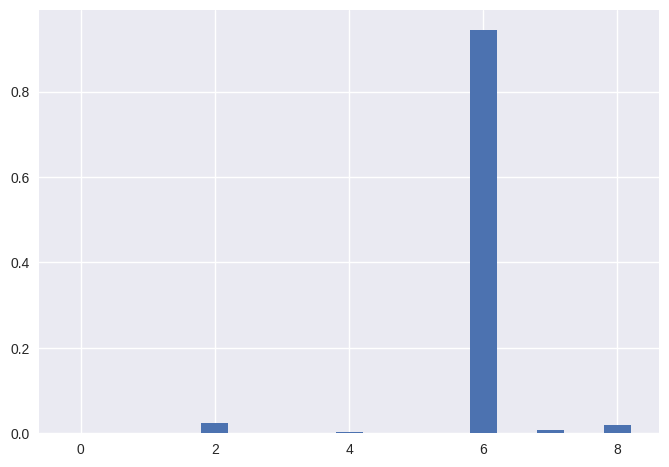

In [18]:
fig, ax = plt.subplots()
ax.bar(range(len(p)), cat.probs, width=0.4)

In [19]:
z = cat.probs

In [20]:
prior_unif = torch.distributions.Uniform(0., 1.)

In [21]:
prior_samples = prior_unif.sample((100, ))

In [22]:
prior_samples

tensor([0.7932, 0.3263, 0.6868, 0.3985, 0.5662, 0.8730, 0.4212, 0.4010, 0.8613,
        0.7082, 0.6234, 0.8298, 0.0427, 0.6418, 0.3125, 0.5551, 0.4838, 0.1427,
        0.3227, 0.5601, 0.5588, 0.8902, 0.7768, 0.5416, 0.4552, 0.7620, 0.4774,
        0.6018, 0.5677, 0.1575, 0.9263, 0.0632, 0.1470, 0.3061, 0.9333, 0.9293,
        0.8432, 0.4871, 0.0163, 0.8957, 0.4081, 0.8811, 0.9030, 0.3579, 0.6751,
        0.7747, 0.1295, 0.4308, 0.9556, 0.4329, 0.4428, 0.0304, 0.4744, 0.3321,
        0.8374, 0.3871, 0.4276, 0.9798, 0.7708, 0.2186, 0.8286, 0.2185, 0.5796,
        0.4996, 0.7953, 0.0362, 0.2441, 0.4488, 0.7355, 0.8618, 0.5947, 0.7233,
        0.1673, 0.0616, 0.6808, 0.8702, 0.6077, 0.2176, 0.0839, 0.2297, 0.7050,
        0.1763, 0.3916, 0.4180, 0.3362, 0.1391, 0.1202, 0.9193, 0.4544, 0.0733,
        0.3431, 0.7541, 0.2225, 0.2909, 0.6722, 0.7381, 0.6580, 0.5017, 0.5327,
        0.0860])

In [23]:
prior_samples_prob = prior_unif.log_prob(prior_samples).exp()

In [24]:
prior_samples_prob 

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

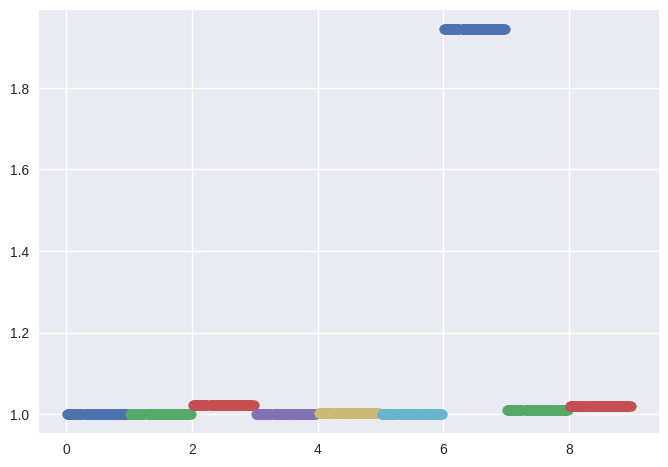

In [25]:
fig, ax = plt.subplots()
for i in range(len(z)):
    ax.scatter(i + prior_samples, z[i] + prior_samples_prob)

In [26]:
z = cat.sample((10000,))
u = prior_unif.sample((10000,))

In [27]:
xp, yp = z + u, p.index_select(0, z)

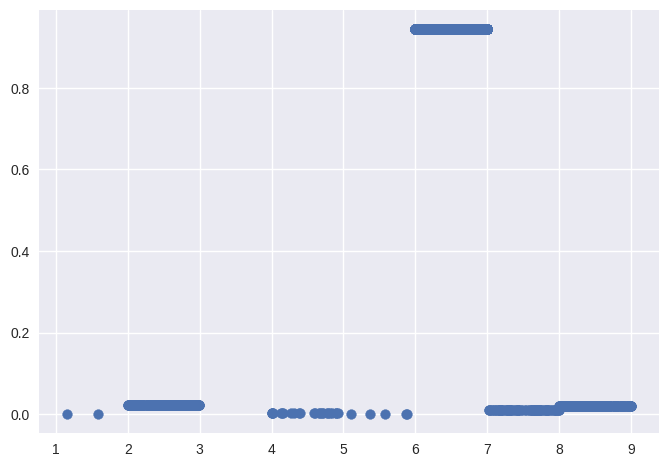

In [28]:
plt.scatter(xp, yp)

In [29]:
torch.manual_seed(52160)
p = torch.zeros(10, dtype=int)
p[8] = 1
cat = torch.distributions.Categorical(p)
cat

Categorical(probs: torch.Size([10]))

In [30]:
x = torch.tensor(8)

In [31]:
u_x = x + prior_unif.sample()
u_x

tensor(8.6793)

In [32]:
u_x / 256.

tensor(0.0339)

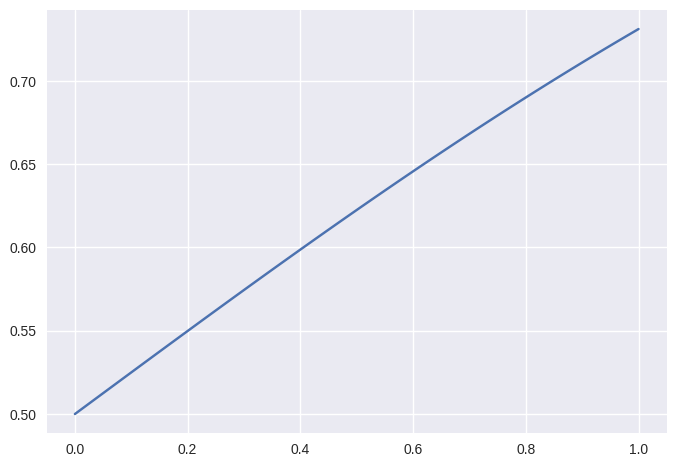

In [33]:
m = torch.linspace(0, 1., 50)
plt.plot(m, torch.sigmoid(m),)

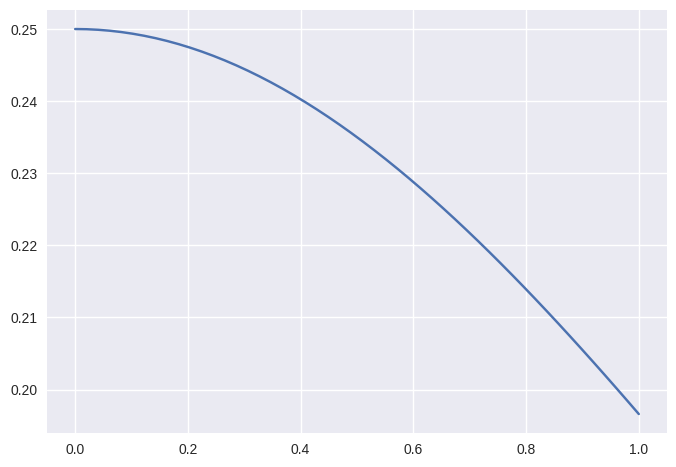

In [34]:
plt.plot(m, torch.sigmoid(m) * ( 1 - torch.sigmoid(m)),)

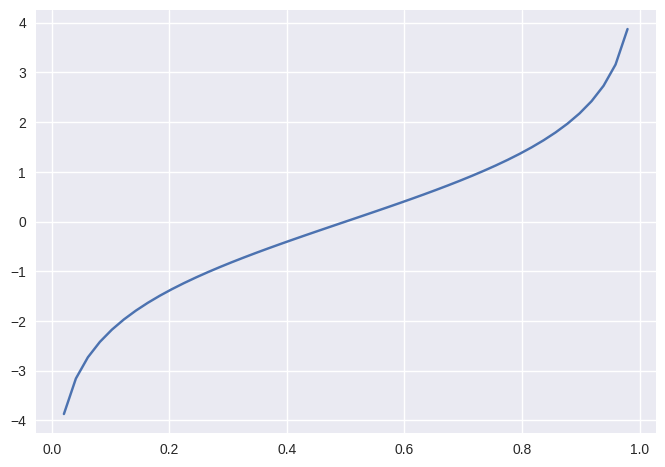

In [35]:
plt.plot(m, torch.log(m) - torch.log( 1 - m),)

In [36]:
class Dequantization(nn.Module):
    
    def __init__(self,  quants=256, alpha=1e-5):
        super().__init__()
        self.quants = quants
        self.alpha = alpha
                    
    def forward(self, x):
        # Uniform Distribution
        z = (x + torch.rand_like(x).detach()) / self.quants
        log_det = -np.prod(z.shape[1:]) * np.log(self.quants)
        
        # Boundary fix for the sigmoid below
        z = z * (1 - self.alpha) + self.alpha
        log_det = log_det  + np.prod(z.shape[1:]) * np.log(1 - self.alpha)
        
        # Inverse sigmoid log(z) - log(1-z)
        # J = 1/z + 1 /(1-z) = 1 / z(1-z) 
        # detJ = prod(1 / z(1-z), dim=[1, 2, 3]) 
        # logdetJ = -sum(log(z) - log(1-z), dim=[1, 2, 3])
        log_det = log_det - (z.abs().log() + (1-z).abs().log()).sum(dim=[1, 2, 3]) 
        z = torch.log(z) - torch.log(1-z)
        
        # new_x = self.reverse(z)
        # print(new_x)
        # print(x)
        # print((new_x - x).max())
        return z, log_det
    
    def reverse(self, z):
        x = torch.sigmoid(z)
        x = (x - self.alpha) / (1 - self.alpha)
        x = x * self.quants
        x = x.floor().clamp(min=0, max=self.quants - 1)
        return x

# Dequantization()(img)      

In [37]:
class NFModel(nn.Module):
    
    def __init__(self, num_flows=32, num_blocks=3):
        super().__init__()
        self.glow = Glow(num_flows=32, num_blocks=3)   
        self.dequantize = Dequantization() 
         
    def forward(self, x):
        z, qlog_det = self.dequantize(x)
        out, z_list, log_p, log_det = self.glow(z)
        log_det = log_det + qlog_det
        return out, z_list, log_p, log_det 
    
    def reverse(self, z):
        x = self.glow.reverse(z)
        x = self.dequantize.reverse(x)
        return x

In [38]:
model = NFModel(num_flows=32, num_blocks=3)
model.cuda()

NFModel(
  (glow): Glow(
    (blocks): ModuleList(
      (0): Block(
        (squeeze): Squeeze()
        (flow_step): ModuleList(
          (0-31): 32 x FlowModule(
            (act_norm): ActNorm()
            (inv_conv): InvConvLU()
            (affine_coupling): AffineCouplingLayer(
              (nn): Sequential(
                (0): Conv2d(6, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): ReLU()
                (2): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
                (3): ReLU()
                (4): Conv2d(512, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              )
            )
          )
        )
        (split): Split(
          (conv_net): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
        )
      )
      (1): Block(
        (squeeze): Squeeze()
        (flow_step): ModuleList(
          (0-31): 32 x FlowModule(
            (act_norm): ActNorm()
            (inv_conv): InvConvLU()
            

In [39]:
model.reverse(model(img.cuda())[1][-1])

tensor([[[[138., 148., 148.,  ...,  37., 199., 213.],
          [219., 178.,  91.,  ...,  38., 149., 154.],
          [209., 185., 146.,  ...,  80., 192.,  67.],
          ...,
          [130., 155.,  99.,  ..., 197.,  52.,  83.],
          [ 86.,  24., 118.,  ..., 119., 165.,  97.],
          [ 77., 176., 192.,  ...,  20., 128., 146.]],

         [[102., 147.,  60.,  ..., 192., 209.,  67.],
          [200., 174., 110.,  ...,  42.,  77., 145.],
          [ 42., 128., 208.,  ...,  98., 221., 211.],
          ...,
          [101.,  95., 163.,  ..., 150., 161., 134.],
          [ 98., 108., 219.,  ..., 198., 208., 150.],
          [118., 114., 171.,  ...,  41., 147.,  28.]],

         [[149., 241., 132.,  ...,  77.,  96., 106.],
          [227., 105., 135.,  ..., 159.,  52., 103.],
          [197., 181., 128.,  ...,  96., 121., 109.],
          ...,
          [121.,  90., 152.,  ..., 136., 206.,  99.],
          [202., 213.,  23.,  ..., 213., 105.,  99.],
          [ 27.,  88.,  48.,  ...

In [40]:
class Trainer:
    
    def __init__(self, model, train_loader, val_loader=None, epochs=0, savepath=None):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)    
        self.savepath = savepath
        if self.savepath is not None:
            os.makedirs(self.savepath, exist_ok=True)

    def fit(self, epoch, loader):
        losses = dict(log_p=[], log_det=[], loss=[])
        for step, img in enumerate(loader):
            out, z_list, log_p, log_det = self.model(img.cuda())
            nll = -(log_det + log_p) / np.prod(img.shape[1:])

            loss = nll.mean()
            
            if torch.isnan(loss).item():
                continue
            
            losses["log_p"].append(log_p.mean().item())
            losses["log_det"].append(log_det.mean().item())
            losses["loss"].append(loss.item())
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 10.)

            if step % 5 == 0:
                print(f"Epoch: {epoch}, step: {step}, loss: {np.mean(losses['loss'])}")
        
        return losses

    def sample_img(self, z):
        with torch.no_grad():
            x = self.model.reverse(z)
            x = x.permute((0, 2, 3, 1))
            x = x.cpu().numpy().astype(np.uint8)
        return x

    def train(self):
        self.train_losses = dict()
        for epoch in range(1, self.epochs + 1):
            losses = self.fit(epoch, train_loader)
            for k, loss_vals in losses.items():
                self.train_losses.setdefault(k, []).extend(loss_vals)
            if epoch % 10 == 0:
                self.evaluate(epoch)
        return self.train_losses
    
    def evaluate(self, epoch=None):
        if self.val_loader is None:
            return
        if epoch is None:
            epoch = 0
        savepath = os.path.join(self.savepath, f"{epoch}")
        os.makedirs(savepath, exist_ok=True)
        img = next(iter(self.val_loader))
        with torch.no_grad():
            out, z_list, log_p, log_det = self.model(img.cuda())
            z = z_list[-1]
            imgs = self.sample_img(z)
            self.save_img(imgs, savepath)
    
    def save_img(self, imgs, savepath):
        for i, img in enumerate(imgs, 1):
            img = Image.fromarray(img)
            img.save(os.path.join(savepath, f"img{i:03d}.jpeg"))
    
            

In [41]:
trainer = Trainer(model, train_loader, val_loader, 1000, savepath="/mnt/dl/generation/glow/")

In [42]:
losses = trainer.train()

Epoch: 1, step: 0, loss: 6.547210693359375
Epoch: 1, step: 5, loss: 6.431819518407186
Epoch: 1, step: 10, loss: 6.34410979531028
Epoch: 1, step: 15, loss: 6.259847581386566
Epoch: 1, step: 20, loss: 6.187811510903495
Epoch: 1, step: 25, loss: 6.137885533846342
Epoch: 1, step: 30, loss: 6.092843486416724
Epoch: 2, step: 0, loss: 5.617392539978027
Epoch: 2, step: 5, loss: 5.7079700628916425
Epoch: 2, step: 15, loss: 5.664781125386556
Epoch: 2, step: 20, loss: 5.623752140998841
Epoch: 2, step: 25, loss: 5.585287551879883
Epoch: 2, step: 30, loss: 5.554923184712728
Epoch: 3, step: 0, loss: 5.342949867248535
Epoch: 3, step: 5, loss: 5.368049144744873
Epoch: 3, step: 10, loss: 5.3433637619018555
Epoch: 3, step: 15, loss: 5.327048480510712
Epoch: 3, step: 20, loss: 5.306049233391171
Epoch: 3, step: 25, loss: 5.289342495111319
Epoch: 3, step: 30, loss: 5.269463892905943
Epoch: 4, step: 5, loss: 5.1367090225219725
Epoch: 4, step: 10, loss: 5.129312038421631
Epoch: 4, step: 15, loss: 5.115601317

KeyboardInterrupt: 

In [ ]:
img = next(iter(val_loader))
       

In [ ]:
img.size()

torch.Size([16, 3, 64, 64])

In [ ]:
with torch.no_grad():
    out, z_list, log_p, log_det = model(img.cuda())
    z = z_list[-1]
    

In [ ]:
torch.std_mean(z, [1, 2, 3])

(tensor([1.2008, 1.0382, 1.1664, 1.0596, 1.0973, 1.1453, 1.0821, 1.0738, 1.0757,
         1.0963, 1.0168, 1.0781, 1.0468, 1.0969, 1.0911, 1.1341],
        device='cuda:0'),
 tensor([-0.0200, -0.0210,  0.0226, -0.0412, -0.0024,  0.0133, -0.0577, -0.0219,
         -0.0239, -0.0068, -0.0283, -0.0183, -0.0336,  0.0168,  0.0112, -0.0207],
        device='cuda:0'))

In [ ]:
with torch.no_grad():
    x = model.glow.reverse(z)
  

In [ ]:
x[0]

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='cuda:0')

In [ ]:
# v = x + u => p(v) = p(x + u)
# z = log(v) - log(1-v)
# det(z/v) = 1 / v(1-v)